# Notebook Setup

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, Math


import numpy as np
import matplotlib.pyplot as plt

import os
import sys

sys.path.insert(1, '../')

from moments_toolkit import moments_toolkit

from moments_toolkit import ratio_formula, sum_ratios_formula

import gvar as gv

from moments_toolkit import plateau_search

import itertools as it

import correlatoranalyser as CA

# Data Reading

In [2]:
p3fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/3PointCorrelation/"
p2fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/2PointCorrelation/"


opAnalyzer = moments_toolkit(p3fold, p2fold,
                            skip3p=False, skipop=False,
                            verbose=True,
                            fast_data_folder = "../fast_data_extended_p0_q0",
                            operator_folder= "../operator_database",
                            momentum='PX0_PY0_PZ0',
                            insertion_momentum = 'qx0_qy0_qz0',
                            tag_2p='hspectrum',
                            max_n=2 #max_n=3
                            )

#opAnalyzer = moments_toolkit(p3fold, p2fold,
#                            skip3p=False, skipop=False,
#                            verbose=True,
#                            fast_data_folder = "../fast_data_extended_px-2_q0",
#                            operator_folder= "../operator_database",
#                            momentum='PX-2_PY0_PZ0',
#                            insertion_momentum = 'qx0_qy0_qz0',
#                            tag_2p='hspectrum',
#                            max_n=2 #max_n=3
#                            )


Initializing the moments_toolkit class instance...


Initializing the building block class instance...


Reading the the keys of the dataset ...


Reading the 2 point and 3 point correlators from the fast access dataset ...


Reading the list of all the available operators from the database...


Class Initialization Complete!



In [3]:
opAnalyzer.set_resampling_type('bootstrap',Nres=1000)

# Operator Selection

In [4]:
#we take the operators of the paper

opV1 = 1/6 * opAnalyzer.get_operator(2)
opV2 = 1/(3 * np.sqrt(2)) * (opAnalyzer.get_operator(2) - opAnalyzer.get_operator(3))
opV3 = 1/np.sqrt(2) * opAnalyzer.get_operator(14)

opA1 = 1/np.sqrt(2) * opAnalyzer.get_operator(28)
opA2 = 1/np.sqrt(2) * opAnalyzer.get_operator(32)

opT1 = opAnalyzer.get_operator(74) + 1/2 * opAnalyzer.get_operator(78)
opT2 = opAnalyzer.get_operator(78)
opT3 =  1/6 * ( -3 * opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) + 3* opAnalyzer.get_operator(91) + opAnalyzer.get_operator(95) )
opT4 = 1/2 * ( opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) -2* opAnalyzer.get_operator(91) )

In [5]:
#we empty the selected op just to be sure
opAnalyzer.deselect_operator()

#we append the operators
opAnalyzer.append_operator(opV1)
opAnalyzer.append_operator(opV2)
opAnalyzer.append_operator(opV3)
opAnalyzer.append_operator(opA1)
opAnalyzer.append_operator(opA2)
opAnalyzer.append_operator(opT1)
opAnalyzer.append_operator(opT2)
opAnalyzer.append_operator(opT3)
opAnalyzer.append_operator(opT4)

#opAnalyzer.append_operator(opAnalyzer.get_operator(125))


#we deselect the op with 0 kin factor
Klist = opAnalyzer.get_Klist()
eliminate_op = [op for op,kin in zip(opAnalyzer.selected_op,Klist) if np.abs( kin.mean ) == 0]
for op in eliminate_op:
    opAnalyzer.deselect_operator(op)

/wsgjsc/home/taggi1/workspace_folders/PhD_work/moments_pdf/test_notebooks/../moments_toolkit.py:1306: RuntimeWarning: invalid value encountered in divide
  cut=np.where(meff_raw/meff_std_raw<=cut_treshold)[0][0]


In [6]:
opAnalyzer.display_operators()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# $\mathcal{S}$ Plots

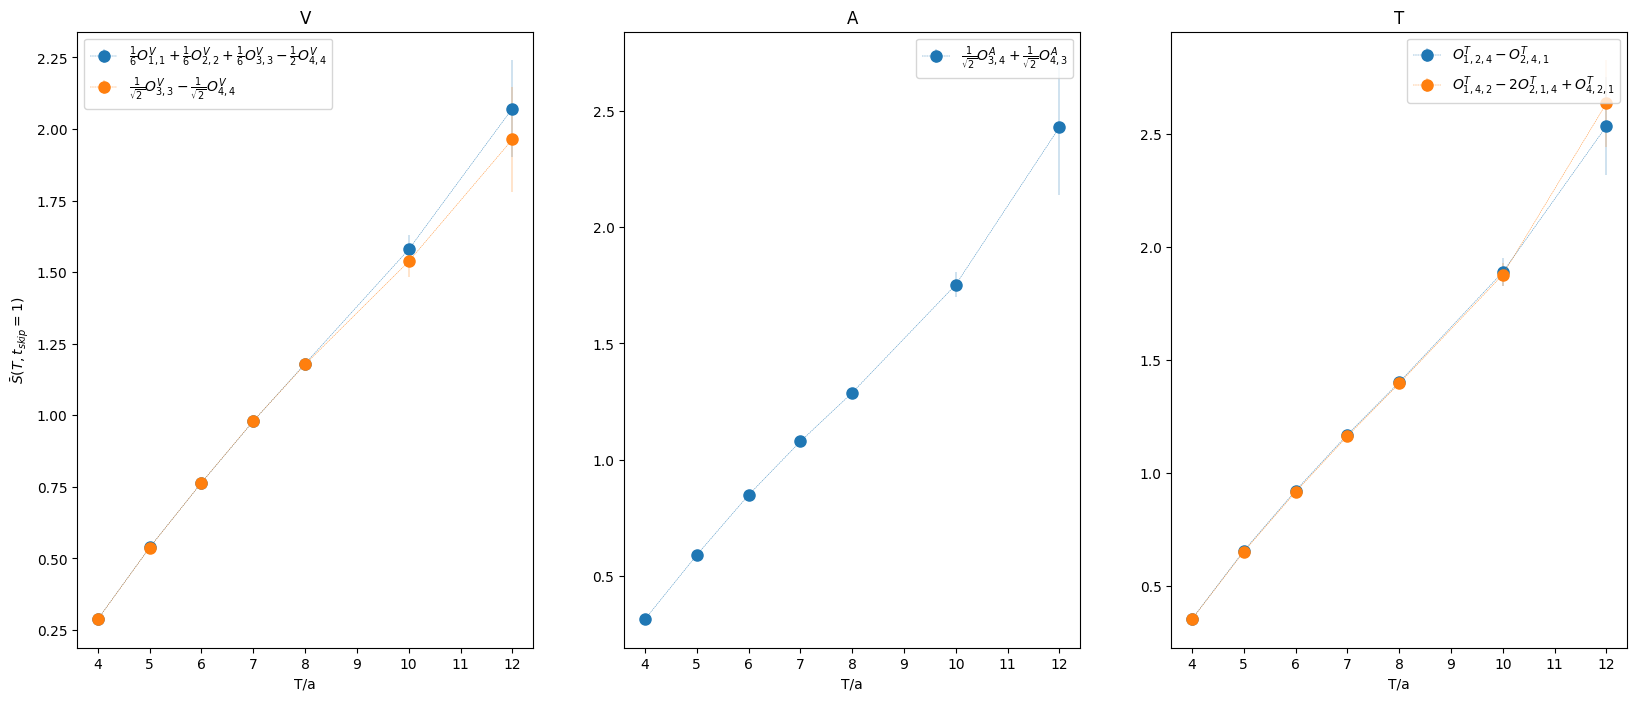

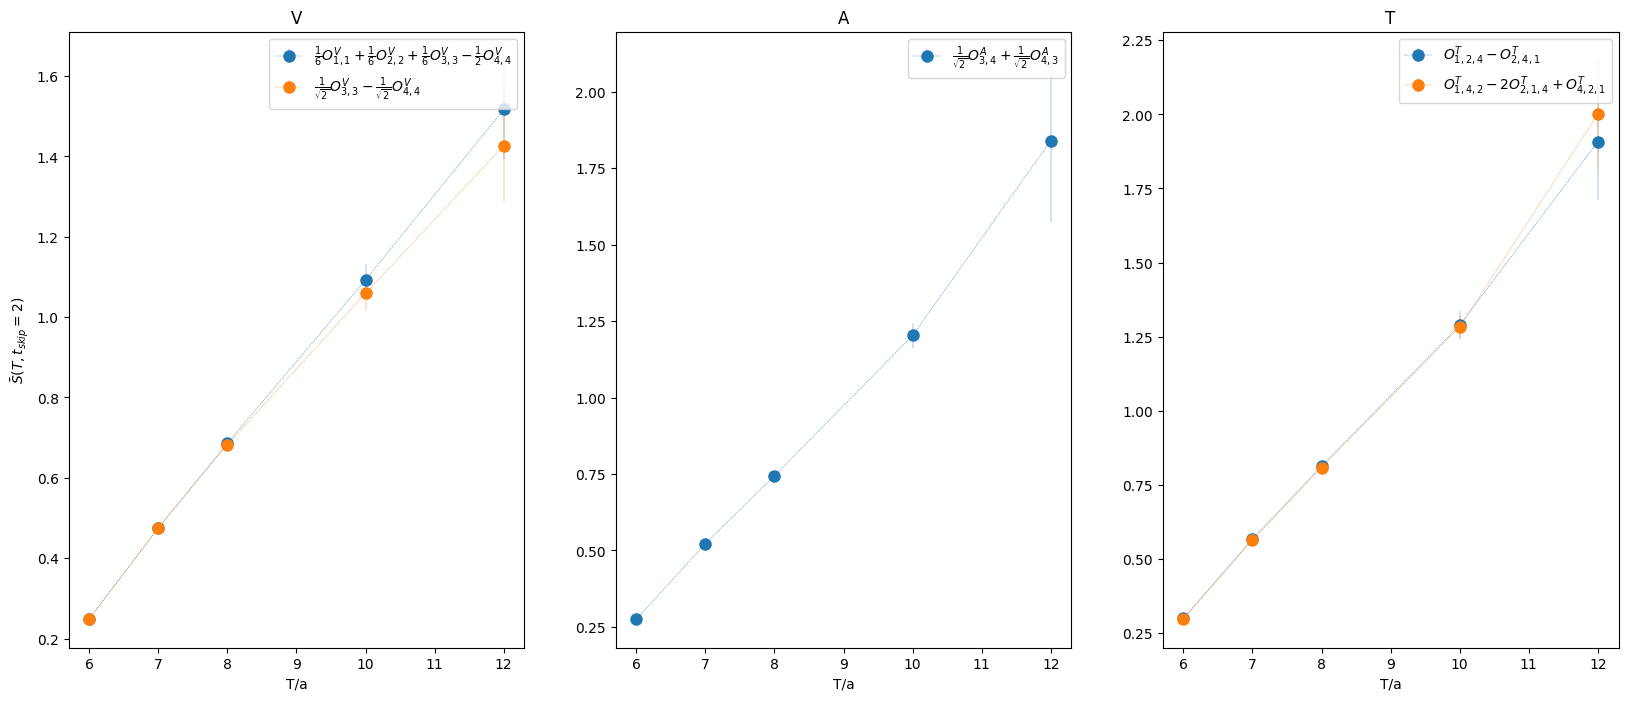

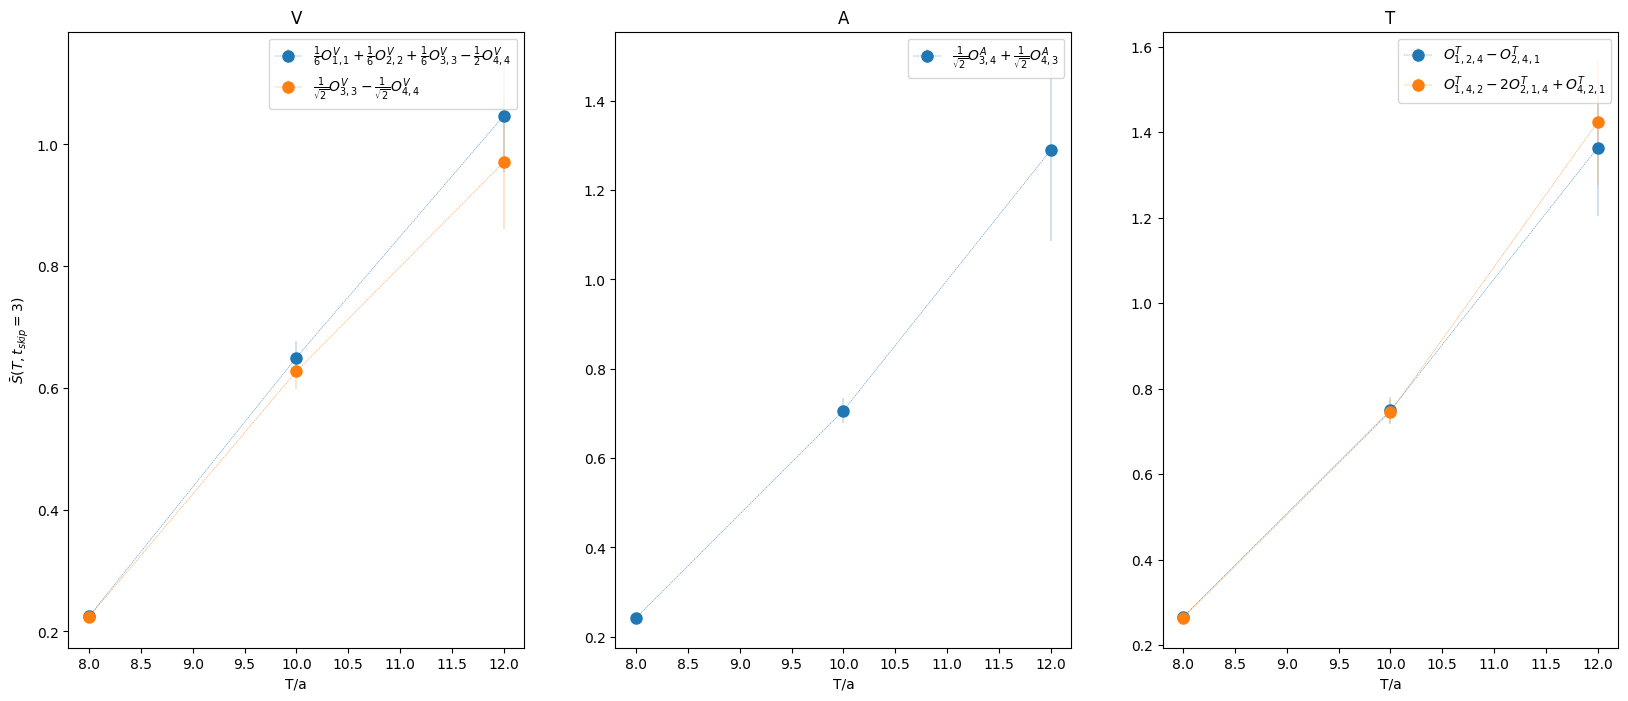

In [7]:
_ = opAnalyzer.plot_S(tskip=1, save=True)
_ = opAnalyzer.plot_S(tskip=2, )
_ = opAnalyzer.plot_S(tskip=3, )

# One Operator Analysis

## Fix iop

In [8]:
#we do the analysis first for one operator
iop = 0

## Matrix Element from Finite Differences

In [9]:
p2corr = opAnalyzer.get_p2corr() #shape = (Nconf, latticeT)
p3corr = opAnalyzer.get_p3corr() #shape = (Nop, Nconf, NT, maxT+1)

#we fix the input
tskip_list = [1,2]
delta_list = [1,2,3]
T_list = opAnalyzer.chosen_T_list[:]


E0 = opAnalyzer.get_E()
m = opAnalyzer.get_m()
p1,p2,p3 = opAnalyzer.get_P()

kin = opAnalyzer.selected_op[iop].evaluate_K_gvar(m_value=m, E_value=E0, p1_value=p1,p2_value=p2,p3_value=p3)

In [10]:


p3_corr = p3corr[iop]
p2_corr = p2corr[:]

#we start by instantiatinh the list with the summed ratios we are going to use, shape = (NT, Ntskip)
S_list = np.zeros(shape=(len(T_list), len(tskip_list)),  dtype=float)

#loop over selected tau skip
for i_tskip, tskip in enumerate(tskip_list):

    #loop over available source sink seprations T
    for iT , T in enumerate(T_list):

        #we compute the summed ratio with the formula
        S_list[iT,i_tskip] = sum_ratios_formula( ratio_formula(p3_corr[:,iT,:], p2_corr, T=T, gauge_axis=0), T, tskip, time_axis=-1)

S_list / kin.mean

array([[0.        , 0.        ],
       [0.28811458, 0.        ],
       [0.53874764, 0.        ],
       [0.76402911, 0.24936975],
       [0.97964725, 0.47555561],
       [1.18051446, 0.68615876],
       [1.57922369, 1.09057089],
       [2.07887385, 1.52221859]])

In [11]:
#we instantiate the list with the allowed matrix elements as empty
mat_ele_array = np.zeros(shape=(len(T_list),len(tskip_list),len(delta_list)), dtype=float) #shape = (nT,)


#we loop over the source-sink separations T, from the cut on
for iT, T in enumerate(T_list):

    #we loop over the values of tau skip
    for itskip,tskip in enumerate(tskip_list):

        if np.abs( S_list[iT,itskip] ) < 10**(-18): continue

        #we loopv over the delta we want to use in the analysis (delta is the separation we use to look at the slope)
        for idelta, delta in enumerate(delta_list):
            
            #a combination T,delta is allowed only if their sum is in the available Ts
            if T + delta in T_list:

                #we check what is the index of the T we have to consider
                iT_plus_delta = T_list.index(T + delta)

                #we compute the matrix element as the slope of the summed ratio function    
                mat_ele_array[iT,itskip,idelta] = (S_list[iT_plus_delta,itskip] - S_list[iT,itskip])/delta

mat_ele_array

mat_ele_mean = np.sum(mat_ele_array) / np.count_nonzero(mat_ele_array)
mean2 =  np.sum(mat_ele_array**2) / np.count_nonzero(mat_ele_array)

mat_ele_std = np.sqrt(mean2 - mat_ele_mean**2) /np.sqrt( np.count_nonzero(mat_ele_array) )

mat_ele = gv.gvar(mat_ele_mean,mat_ele_std)
mat_ele

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.0713528 , 0.06774412, 0.06562421],
        [0.        , 0.        , 0.        ]],

       [[0.06413545, 0.06275992, 0.06090159],
        [0.        , 0.        , 0.        ]],

       [[0.06138439, 0.05928467, 0.        ],
        [0.06439292, 0.06217479, 0.        ]],

       [[0.05718494, 0.        , 0.05689786],
        [0.05995667, 0.        , 0.05836296]],

       [[0.        , 0.05675432, 0.        ],
        [0.        , 0.0575661 , 0.        ]],

       [[0.        , 0.07112277, 0.        ],
        [0.        , 0.06144295, 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]]])

0.0622(10)

In [12]:


mom = mat_ele / kin
mom

0.2184(38)

### plot

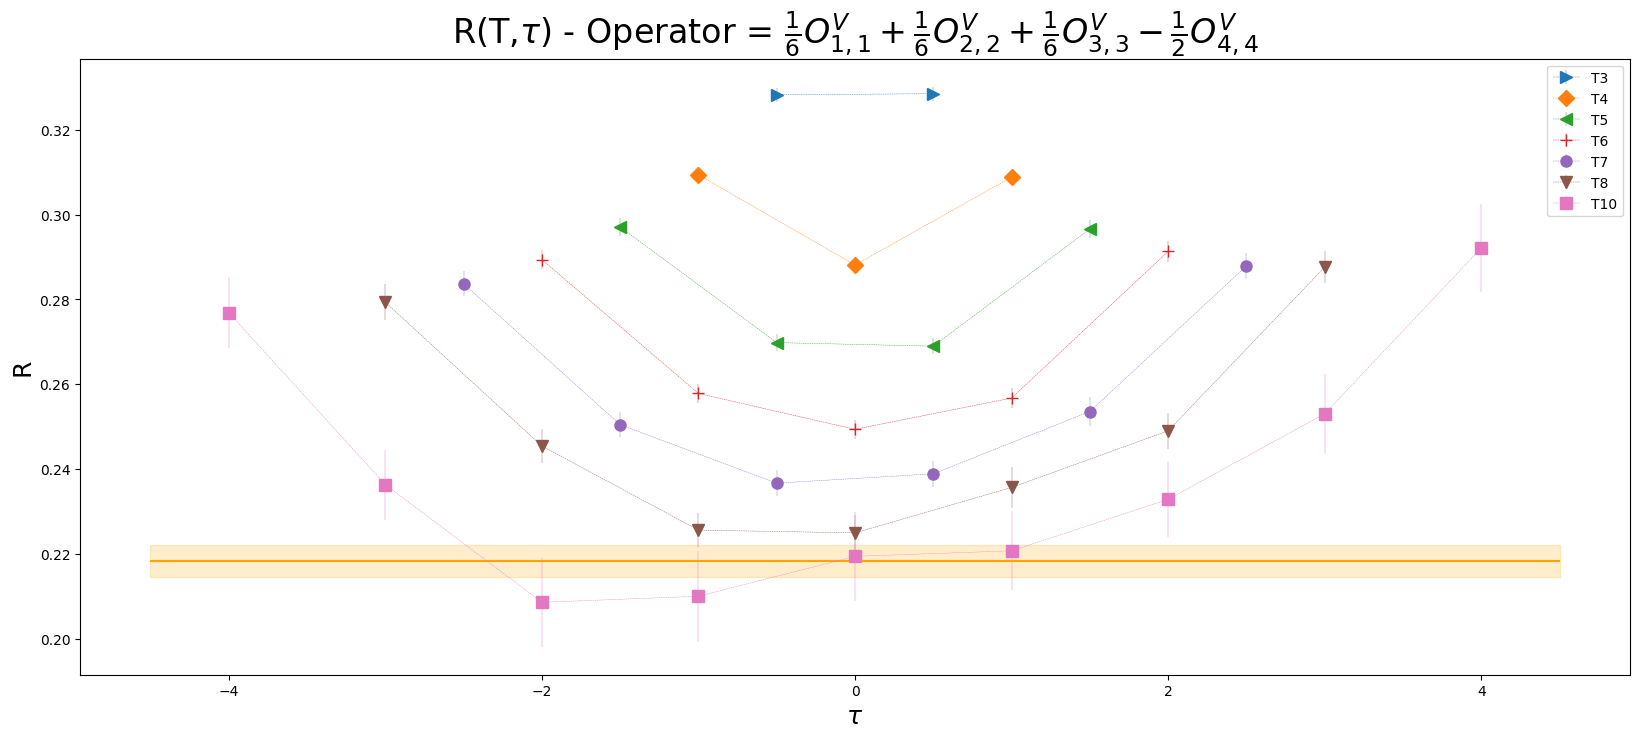

In [13]:
opAnalyzer.remove_T(12,verbose=False)
fig_ax_list = opAnalyzer.plot_R(rescale=True,show=False,save=True)

fig, ax = fig_ax_list[iop]

Tmax = 11

_ = ax.hlines(mom.mean,-Tmax/2+1,Tmax/2-1,linestyle="solid", color="orange")

_ = ax.fill_between(np.arange(-Tmax/2+1,Tmax/2), mom.mean - mom.sdev, mom.mean + mom.sdev, alpha=0.2, color="orange")

for jop in range(opAnalyzer.Nop):
    if jop!=iop:
        plt.close(fig_ax_list[jop][0])
plt.show()
opAnalyzer.remove_T()

## Matrix Element from Fit

In [14]:
tskip=1
Smean, Sstd = opAnalyzer.get_S(tskip=tskip)

#the treshold value that should be removed is
T_treshold = 1 + 2*tskip #because we want to have (T+1) -2 -2tau_skip > 0

#we instantiate the times T to plot to the full list
T_plot = opAnalyzer.chosen_T_list[:]

#we loop over all the smaller values of T to find the one from which we should start cutting the data
for T in range(T_treshold, opAnalyzer.chosen_T_list[0]-1,-1):

    #when (and if) we find the biggest value that can be removed, we remove from it onward and stop the loop
    if T in opAnalyzer.chosen_T_list:

        #the index from where we will cut is
        iT_cut = opAnalyzer.chosen_T_list.index(T) + 1

        #we cut the relevant arrays (the x and y of the plots)
        T_plot = opAnalyzer.chosen_T_list[iT_cut:]
        Smean = Smean[iop,iT_cut:]
        Sstd = Sstd[iop,iT_cut:]

        #we stop the loop if we find one of such values
        break

T_plot
Smean
Sstd

[4, 5, 6, 7, 8, 10, 12]

array([0.08202803, 0.1533758 , 0.21750514, 0.27879103, 0.33587192,
       0.44976175, 0.58897469])

array([0.00030007, 0.00080254, 0.00145301, 0.00265416, 0.00497908,
       0.01410766, 0.05061091])

In [15]:
prior = gv.BufferDict()


slope_mean = (Smean[-1] - Smean[0]) / (T_plot[-1] - T_plot[0])
intercept_mean = Smean[0] - slope_mean * T_plot[0]

prior["m"] = gv.gvar(slope_mean,slope_mean)
prior["q"] = gv.gvar(intercept_mean,intercept_mean)

prior

BufferDict({'m': 0.063(63), 'q': -0.17(17)})

In [16]:
def lin_func(x,p):
    return p["m"]*x+p["q"]

In [17]:
#we do the fit
fit_result = CA.fit(

    abscissa                = np.asarray(T_plot),
    
    ordinate_est            = Smean, 
    ordinate_std            =  Sstd, 
    ordinate_cov            =   None, 
    
    resample_ordinate_est   = None,
    resample_ordinate_std   = None, 
    resample_ordinate_cov   = None,

    # fit strategy, default: only uncorrelated central value fit:
    central_value_fit            = True,
    central_value_fit_correlated = False,

    resample_fit                 = False,
    resample_fit_correlated      = False,
    
    resample_fit_resample_prior  = False,
    resample_type               = "bst", #"jkn",                  #TO DO: update this param as soon as the class gets corrected

    # args for lsqfit:
    model   = lin_func,
    prior   = prior,
    p0      = None,

    svdcut  = None,
    maxiter = 10_000,
)

#fit_result_lin = CA.linear_regression(
#
#    abscissa                = np.asarray(T_plot),
#    
#    ordinate_est            = Smean, 
#    ordinate_std            =  Sstd, 
#    ordinate_cov            =   None, 
#    
#    resample_ordinate_est   = None,
#    resample_ordinate_std   = None, 
#    resample_ordinate_cov   = None,
#
#    # fit strategy, default: only uncorrelated central value fit:
#    central_value_fit            = True,
#    central_value_fit_correlated = False,
#
#    resample_fit                 = False,
#    resample_fit_correlated      = False,
#    
#    resample_type               = "bst", #"jkn",                  #TO DO: update this param as soon as the class gets corrected
#
#    # args for lsqfit:
#    has_intercept=True,
#    parameter_names=["m","q"]
#)

In [18]:
fit_result

fit_result.best_fit_param["m"] / kin

FitResult[ (4,12), Ndata=7, resample:False]:
  𝜒²/dof [dof] = 6.29 [7]
  AIC = 37 
    - m: 0.06731(45)  [0.063(63)]
    - q: -0.1868(19)  [-0.17(17)]

0.2364(19)

In [19]:
Zfact = gv.gvar(1.0736,0.0202) * gv.gvar(0.9094,0.0036)
Zfact

fit_result.best_fit_param["m"] / kin * Zfact

0.976(19)

0.2308(48)

In [20]:
fit_result

fit_result.best_fit_param["m"] / kin

FitResult[ (4,12), Ndata=7, resample:False]:
  𝜒²/dof [dof] = 6.29 [7]
  AIC = 37 
    - m: 0.06731(45)  [0.063(63)]
    - q: -0.1868(19)  [-0.17(17)]

0.2364(19)

<ErrorbarContainer object of 3 artists>

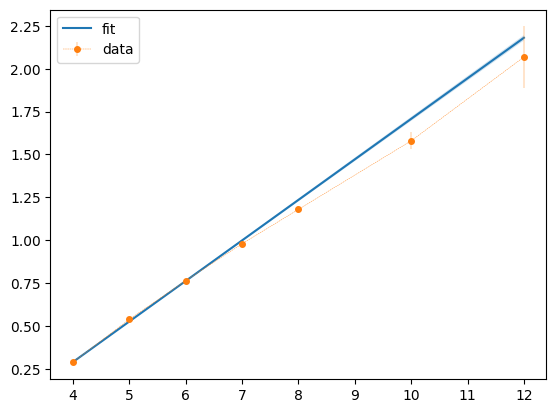

In [21]:
abscissa = np.arange(fit_result.ts, fit_result.te+1)
ordinate = fit_result.eval(abscissa) 

ordinate = gv.gvar(ordinate["est"],ordinate["err"]) / kin

ordinate_data = gv.gvar(Smean,Sstd) / kin

plt.plot( abscissa, [o.mean for o in ordinate],
                      linestyle="-",label="fit")

plt.fill_between(abscissa, [o.mean + o.sdev for o in ordinate] ,  [o.mean - o.sdev for o in ordinate] , alpha= 0.2,)

plt.errorbar(T_plot, [e.mean for e in ordinate_data], yerr=[e.sdev for e in ordinate_data], marker = 'o', markersize = 4, linewidth = 0.3, linestyle='dashed',label="data")
plt.legend()

In [22]:
np.arange(fit_result.ts, fit_result.te+1)
T_plot

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12])

[4, 5, 6, 7, 8, 10, 12]

In [23]:
ordinate_tmp = fit_result.eval(np.asarray(T_plot))
ordinate_fit = gv.gvar(ordinate_tmp["est"],ordinate_tmp["err"]) / kin

res = ordinate_fit -ordinate_data
res

array([0.0014(15), -0.0128(32), -0.0017(59), 0.020(10), 0.055(19),
       0.128(50), 0.11(18)], dtype=object)

<ErrorbarContainer object of 3 artists>

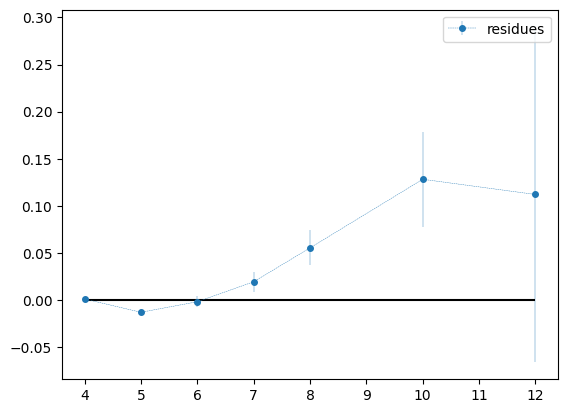

In [24]:

plt.errorbar(T_plot, [e.mean for e in res], yerr=[e.sdev for e in res], marker = 'o', markersize = 4, linewidth = 0.3, linestyle='dashed',label="residues")

plt.hlines(0,xmin=min(T_plot), xmax=max(T_plot),color="black")

plt.legend()

In [25]:
data_nd = opAnalyzer.get_p3corr()
data_nd.shape

n_resamples = 99

nconf = data_nd.shape[1]

np.take(data_nd, np.random.randint(nconf, size=nconf*n_resamples), axis=1 ).reshape(n_resamples, *data_nd.shape).shape

(5, 212, 8, 13)

(99, 5, 212, 8, 13)

In [26]:
bts_resamples = np.take(data_nd, np.random.randint(nconf, size=nconf*n_resamples), axis=1 ).reshape(n_resamples, *data_nd.shape)

bts_mean = bts_resamples.mean(axis=0)
bts_std = bts_resamples.std(axis=0) / np.sqrt(n_resamples-1)

#bts_cov = np.cov(bts_resamples)
bts_mean

array([[[[-7.75488038e-14,  2.00173273e-13,  2.00099106e-13, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-4.51302047e-14,  1.00851307e-13,  9.08087409e-14, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-2.64307534e-14,  5.44315515e-14,  4.74638562e-14, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [-4.85041261e-15,  9.23054718e-15,  8.20128457e-15, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-1.86294157e-15,  2.75113022e-15,  2.44857660e-15, ...,
          -1.84663456e-15,  0.00000000e+00,  0.00000000e+00],
         [-3.57609024e-16,  9.98412210e-16,  7.50377278e-16, ...,
           5.92077664e-16,  8.18535125e-16, -4.73004602e-16]],

        [[-7.98049366e-14,  2.01881541e-13,  2.02327118e-13, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-4.72855017e-14,  1.00981599e-13,  9.24629456e-14, ...,
           0.00000000e

In [27]:
np.random.randint(10,size=5)

array([7, 2, 2, 2, 9])

In [28]:
data_nd = opAnalyzer.get_p3corr()[0]
data_nd.shape

n_resamples = 99
data_nd[np.random.randint(len(data_nd), size=len(data_nd)*n_resamples)].reshape(n_resamples, *data_nd.shape).shape

(212, 8, 13)

(99, 212, 8, 13)

# Systematic Comparison

Finite differences

$$\mathcal{M} (T) = AVG_{\delta,\tau_{skip}} \left[ \frac{S(T+\delta,\tau_{skip}) - S(T,\tau_{skip})}{\delta} \right]$$

Fit

$$\mathcal{M} (T) = AVG_{\tau_{skip}} \left[ SlopeFromFit\left( T_{min}=T, S(:, \tau_{skip}) \right) \right]$$


In [29]:
tskip_list = [1,2,3] if True else [1]
delta_list = [1,2,3] if True else [1,2]

Klist = opAnalyzer.get_Klist()

opAnalyzer.chosen_T_list

[3, 4, 5, 6, 7, 8, 10, 12]

## Finite differences

In [30]:
from moments_toolkit import jackknife,MatEle_from_slope_formula

In [31]:
#we first take the correlators we need to compute everything
p2corr = opAnalyzer.get_p2corr() #shape = (Nconf, latticeT)
p3corr = opAnalyzer.get_p3corr() #shape = (Nop, Nconf, NT, maxT+1)

#we instantiate the output array
mat_ele_array = np.zeros(shape=(opAnalyzer.Nop, opAnalyzer.nT), dtype=object ) #shape = (Nop, nT)
moments_array = np.zeros(shape=(opAnalyzer.Nop, opAnalyzer.nT), dtype=object ) #shape = (Nop, nT)


#we fill the output array using the formula for the matrix element from S
for iop in range(opAnalyzer.Nop):

    #we compute mean and std of the matrix element using the jackknife
    mat_ele, mat_ele_std, _ = jackknife([p3corr[iop],p2corr], observable = lambda x,y: MatEle_from_slope_formula(p3_corr=x, p2_corr=y, T_list=opAnalyzer.chosen_T_list, delta_list=delta_list, tskip_list=tskip_list), res_axis_list=[0,0], time_axis=None)

    #we put them into a gvar variable and store it into the array
    mat_ele_array[iop] = gv.gvar(mat_ele,mat_ele_std)
    moments_array[iop] = gv.gvar(mat_ele,mat_ele_std) / Klist[iop]

In [32]:
mat_ele_array
moments_array

array([[0 ± 0, 0.06824(64), 0.0626(11), 0.0618(15), 0.0581(29),
        0.0583(46), 0.063(18), 0 ± 0],
       [0 ± 0, 0.09654(99), 0.0887(17), 0.0872(23), 0.0788(44),
        0.0763(72), 0.077(29), 0 ± 0],
       [0 ± 0, -0.10702(92), -0.0984(17), -0.0936(23), -0.0886(41),
        -0.0928(72), -0.127(46), 0 ± 0],
       [0 ± 0, 0.1629(16), 0.1467(27), 0.1443(37), 0.1362(70), 0.137(11),
        0.178(46), 0 ± 0],
       [0 ± 0, 0.3231(27), 0.2917(42), 0.2871(61), 0.272(12), 0.272(20),
        0.407(86), 0 ± 0]], dtype=object)

array([[0 ± 0, 0.2397(25), 0.2199(40), 0.2171(53), 0.204(10), 0.205(16),
        0.220(63), 0 ± 0],
       [0 ± 0, 0.2398(27), 0.2203(43), 0.2166(57), 0.196(11), 0.190(18),
        0.191(71), 0 ± 0],
       [0 ± 0, 0.2658(26), 0.2444(43), 0.2324(58), 0.220(10), 0.230(18),
        0.32(11), 0 ± 0],
       [0 ± 0, 0.2860(32), 0.2576(48), 0.2534(67), 0.239(12), 0.240(20),
        0.312(81), 0 ± 0],
       [0 ± 0, 0.2838(27), 0.2562(39), 0.2521(55), 0.239(11), 0.239(17),
        0.358(76), 0 ± 0]], dtype=object)

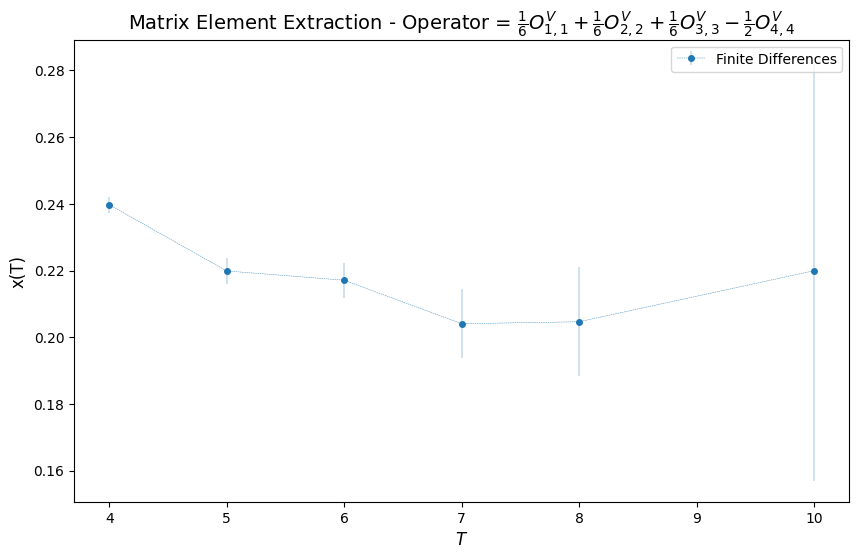

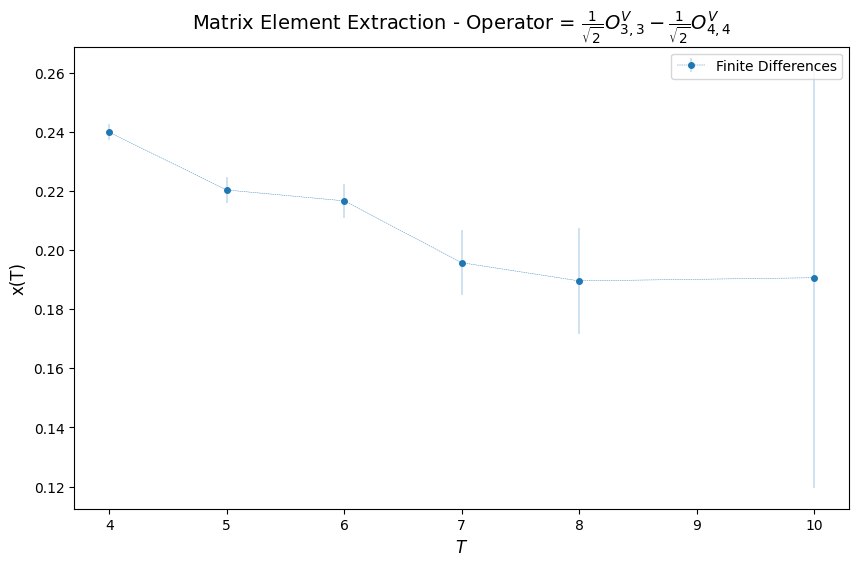

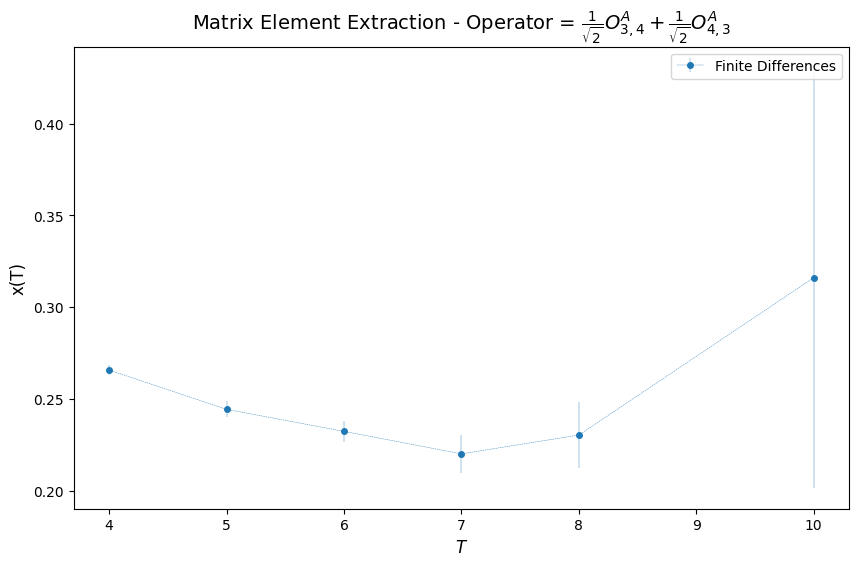

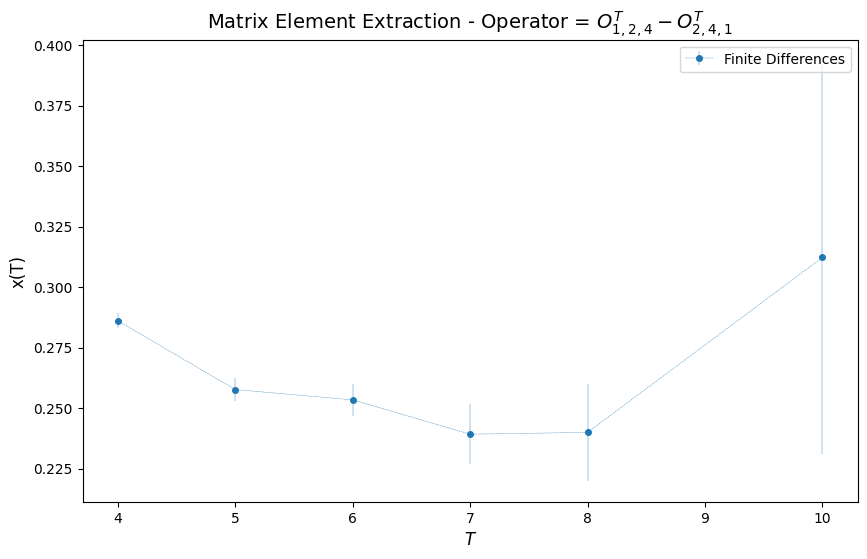

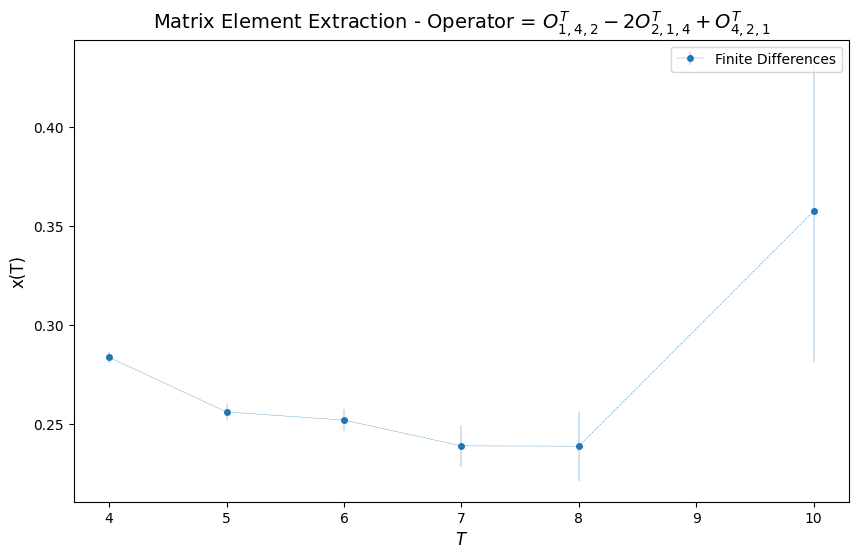

In [33]:
moments = True

#loop over selected operators (for each we make a plot)
for iop,op in enumerate(opAnalyzer.selected_op):

    ordinate_array = moments_array if moments else mat_ele_array
    
    #instantiate figure
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))

    asc = [T for i,T in enumerate(opAnalyzer.chosen_T_list) if np.abs(ordinate_array[iop][i].mean)>10**(-18)]
    ord = [e.mean for e in ordinate_array[iop] if np.abs(e.mean)>10**(-18)]
    ord_sig = [e.sdev for e in ordinate_array[iop] if np.abs(e.mean)>10**(-18)]

    _=ax.errorbar(asc, ord,yerr=ord_sig, marker = 'o', markersize = 4, linewidth = 0.3, linestyle='dashed',label=f"Finite Differences")

    _=ax.legend()
    _=ax.set_title(r"Matrix Element Extraction - Operator = ${}$".format(op),fontsize=14)
    _=ax.set_xlabel(r"$T$", fontsize=12)
    _=ax.set_ylabel(r"x(T)" if moments else r"\mathcal{M}(T)", fontsize=12)

## Fit

In [34]:
#we fetch the summed ratios
Smean_array = np.zeros(shape=(len(tskip_list),opAnalyzer.Nop,opAnalyzer.nT))
Sstd_array = np.zeros(shape=(len(tskip_list),opAnalyzer.Nop,opAnalyzer.nT))
for itskip,tskip in enumerate(tskip_list):
    Smean, Sstd = opAnalyzer.get_S(tskip=tskip)
    Smean_array[itskip] = Smean
    Sstd_array[itskip] = Sstd

In [35]:
def lin_func(x,p):
    return p["m"]*x+p["q"]

In [36]:
mat_ele_array_fit = np.zeros(shape=(opAnalyzer.Nop, opAnalyzer.nT), dtype=object ) #shape = (Nop, nT)
moments_array_fit = np.zeros(shape=(opAnalyzer.Nop, opAnalyzer.nT), dtype=object ) #shape = (Nop, nT)


#loop over different operators
for iop,op in enumerate(opAnalyzer.selected_op):

    #loop over starting times
    for iTstart, Tstart in enumerate(opAnalyzer.chosen_T_list):

        #for each tuple (operator,starting time) we instantiate a fit state
        fit_state = CA.FitState()

        ## we want to average over various fit changing the value of tskip and that of the last time considered 

        for itskip,tskip in enumerate(tskip_list):

            #we skip the value of tskip that are not allowed
            if tskip >= (Tstart-1)/2: continue

            #we loop over the maximum time considered
            for iTend,Tend in enumerate(opAnalyzer.chosen_T_list):

                #we skip all the endtimes that are smaller (by 2) w.r.t. the start time
                if iTend-iTstart < 3: continue

                #we determine the fit abscissa and ordinate
                abscissa = np.asarray( opAnalyzer.chosen_T_list[iTstart:iTend+1] )
                #if iop==0: print(abscissa)
                ordinate = Smean_array[itskip,iop,iTstart:iTend+1]
                ordinate_err = Sstd_array[itskip,iop,iTstart:iTend+1]

                #we determine the prior
                prior = gv.BufferDict()

                slope = (ordinate[-1] - ordinate[0]) / (abscissa[-1] - abscissa[0])
                intercept = ordinate[0] - slope * abscissa[0]

                prior["m"] = gv.gvar(slope,slope) #100% error
                prior["q"] = gv.gvar(intercept,intercept)

                #if iop==0: f"performing the fit for Tstart {Tstart}, tskip {tskip}, Tend {Tend} (len abscissa = {len(abscissa)}) "

                #we do the fit
                fit_result = CA.fit(

                    abscissa                = abscissa,
                    
                    ordinate_est            = ordinate, 
                    ordinate_std            =  ordinate_err, 
                    ordinate_cov            =   None, 
                    
                    resample_ordinate_est   = None,
                    resample_ordinate_std   = None, 
                    resample_ordinate_cov   = None,

                    # fit strategy, default: only uncorrelated central value fit:
                    central_value_fit            = True,
                    central_value_fit_correlated = False,

                    resample_fit                 = False,
                    resample_fit_correlated      = False,
                    
                    resample_fit_resample_prior  = False,
                    resample_type               = "bst", #"jkn",                  #TO DO: update this param as soon as the class gets corrected

                    # args for lsqfit:
                    model   = lin_func,
                    prior   = prior,
                    p0      = None,

                    svdcut  = None,
                    maxiter = 10_000,
                )

                #if iop==0: f"Nparam = {len(fit_result.best_fit_param.keys())}, Ndata = {fit_result.Ndata}, te = {fit_result.te}, ts = {fit_result.ts}"

                #we append the fit result to the fit state
                fit_state.append(fit_result)


        

        mat_ele_array_fit[iop,iTstart] = gv.gvar(fit_state.model_average()["est"]["m"],fit_state.model_average()["err"]["m"]) if len(fit_state.model_average())>0 else gv.gvar(0,0)
        moments_array_fit[iop,iTstart] = mat_ele_array_fit[iop,iTstart] / Klist[iop]

        


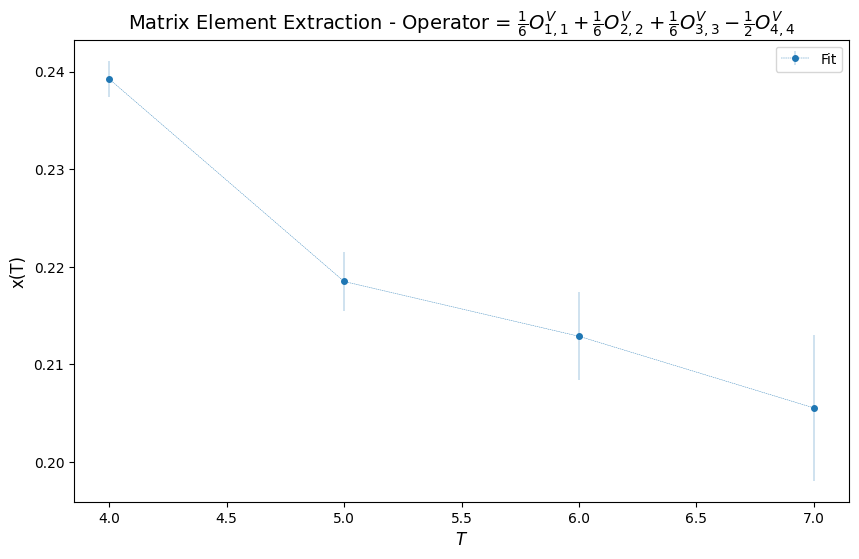

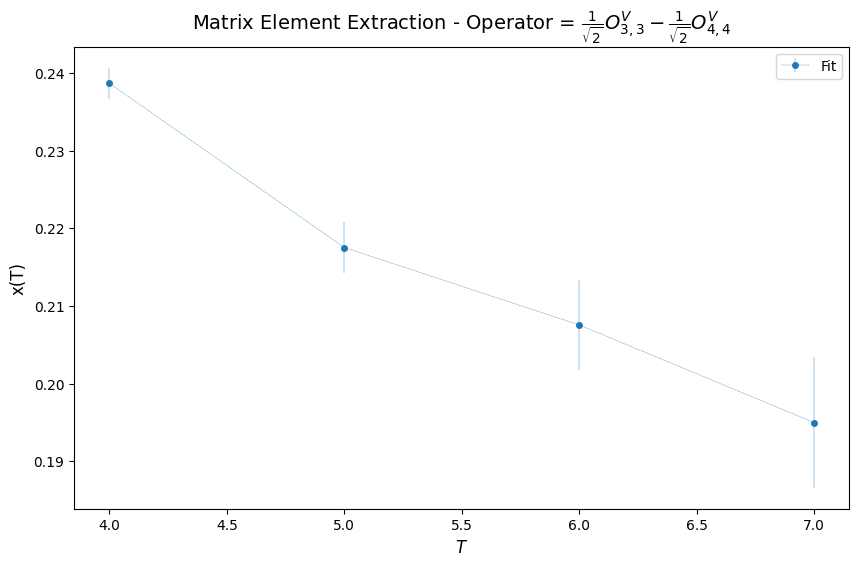

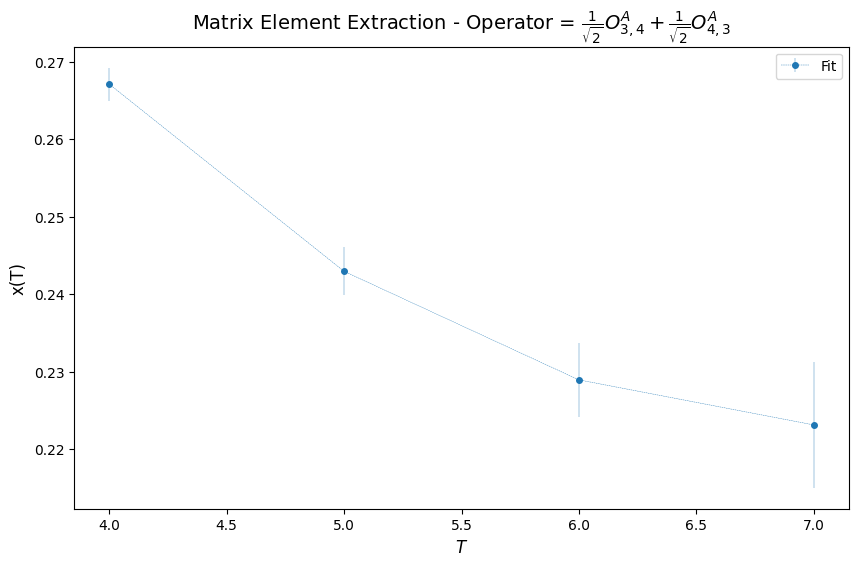

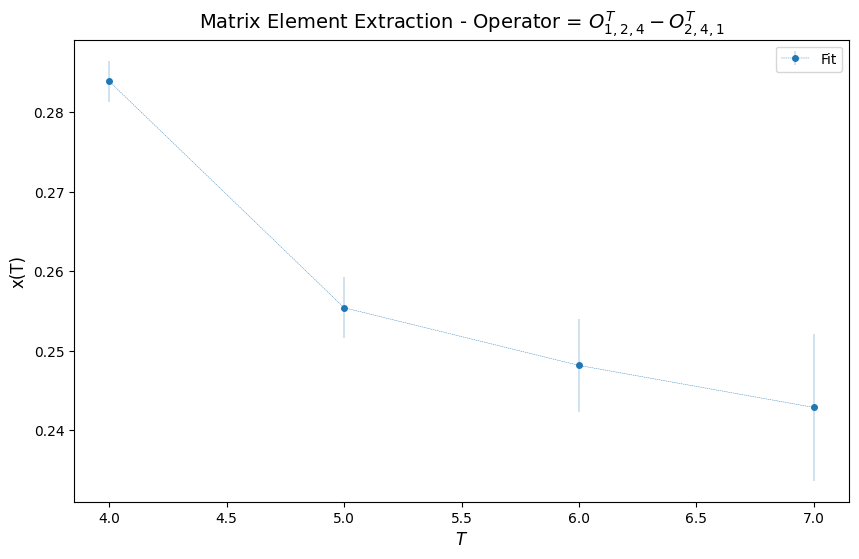

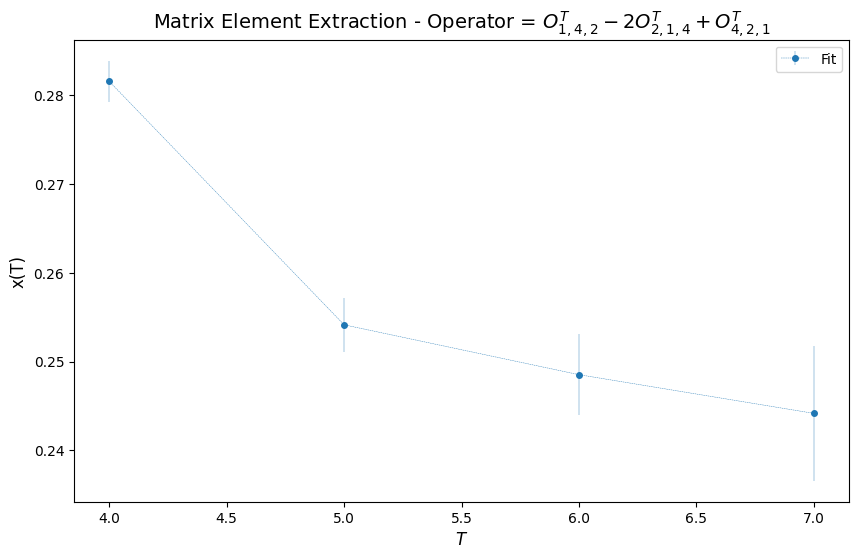

In [37]:
moments = True

#loop over selected operators (for each we make a plot)
for iop,op in enumerate(opAnalyzer.selected_op):

    ordinate_array = moments_array_fit if moments else mat_ele_array_fit
    
    #instantiate figure
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))

    asc = [T for i,T in enumerate(opAnalyzer.chosen_T_list) if np.abs(ordinate_array[iop][i].mean)>10**(-18)]
    ord = [e.mean for e in ordinate_array[iop] if np.abs(e.mean)>10**(-18)]
    ord_sig = [e.sdev for e in ordinate_array[iop] if np.abs(e.mean)>10**(-18)]

    _=ax.errorbar(asc, ord,yerr=ord_sig, marker = 'o', markersize = 4, linewidth = 0.3, linestyle='dashed',label=f"Fit")

    _=ax.legend()
    _=ax.set_title(r"Matrix Element Extraction - Operator = ${}$".format(op),fontsize=14)
    _=ax.set_xlabel(r"$T$", fontsize=12)
    _=ax.set_ylabel(r"x(T)" if moments else r"\mathcal{M}(T)", fontsize=12)

## Comparison

In [38]:
opAnalyzer.set_resampling_type('bootstrap',Nres=1000)

#usage of the new method
moments_array_fit = opAnalyzer.get_M_from_S(method="fit",moments=True, tskip_list=[1,2,3])
mat_ele_array_fit = opAnalyzer.get_M_from_S(method="fit",moments=False, tskip_list=[1,2,3])
moments_array = opAnalyzer.get_M_from_S(method="finite differences",moments=True, tskip_list=[1,2,3],delta_list=[1,2,3])
mat_ele_array = opAnalyzer.get_M_from_S(method="finite differences",moments=False, tskip_list=[1,2,3],delta_list=[1,2,3])

from moments_toolkit import average_moments_over_T

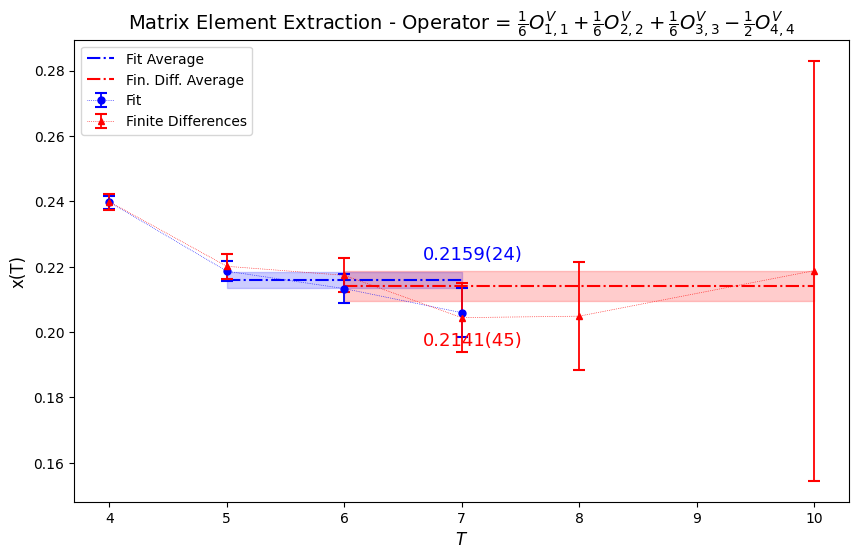

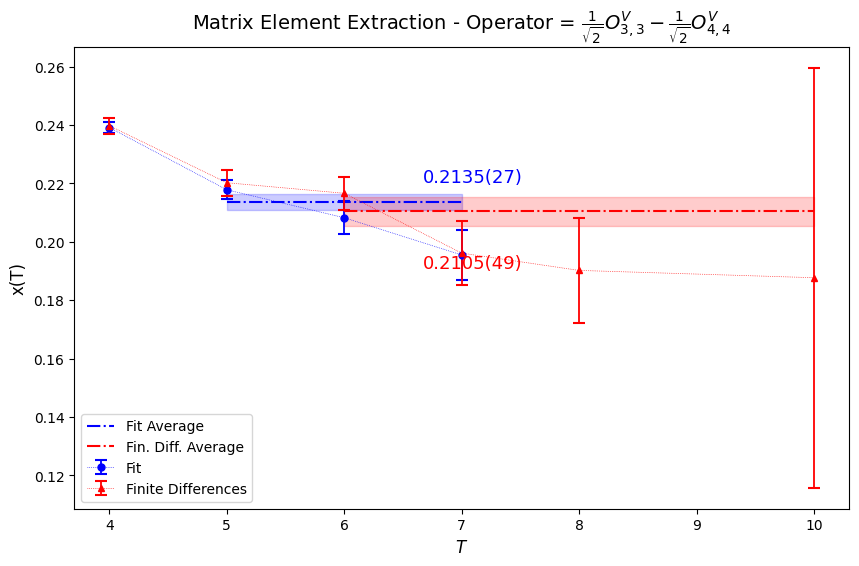

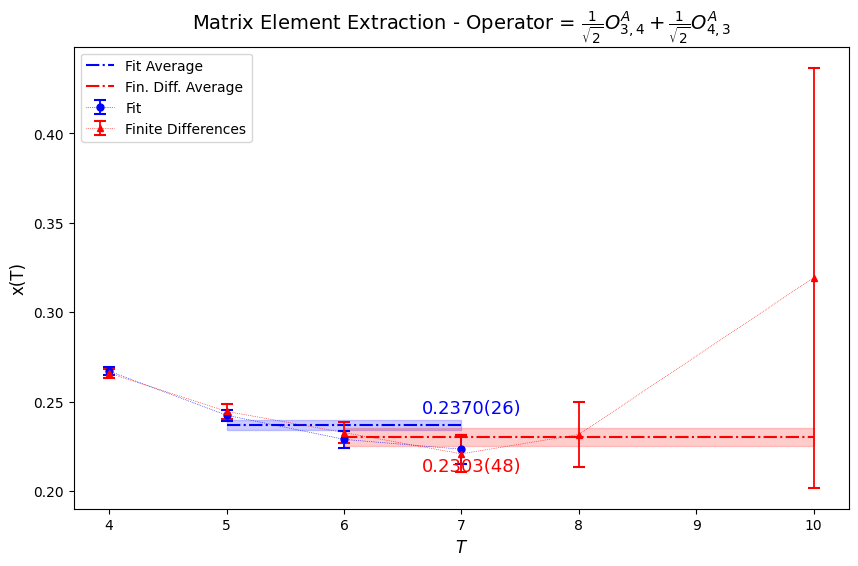

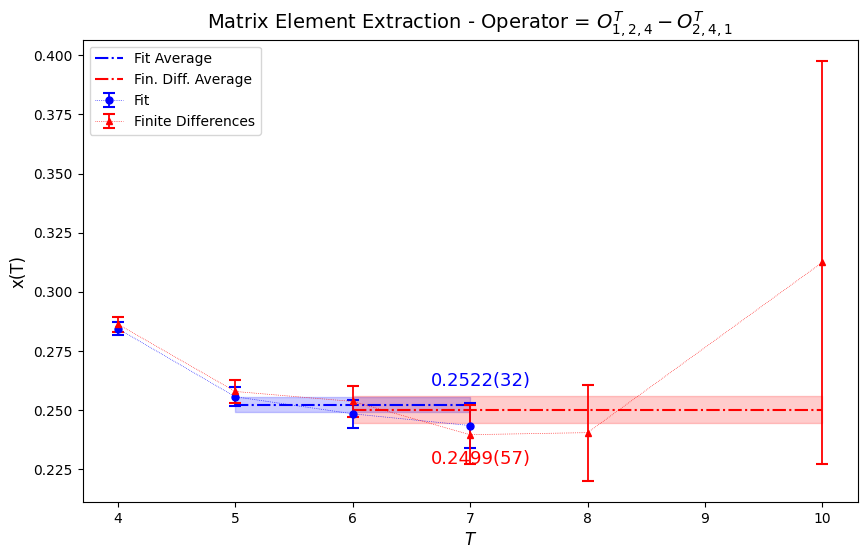

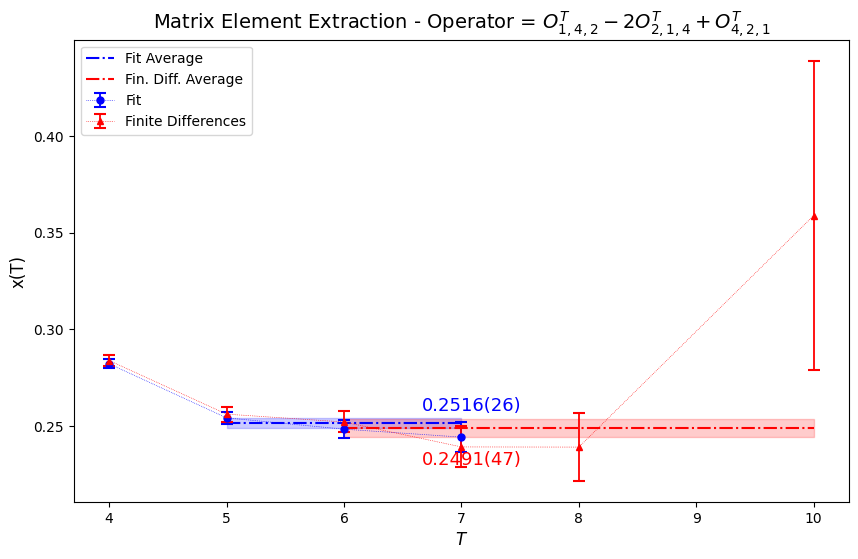

In [39]:
moments = True

#loop over selected operators (for each we make a plot)
for iop,op in enumerate(opAnalyzer.selected_op):

    #instantiate figure
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))

    ordinate_array_fit = moments_array_fit if moments else mat_ele_array_fit
    

    asc = np.array( [T for i,T in enumerate(opAnalyzer.chosen_T_list) if np.abs(ordinate_array_fit[iop][i].mean)>10**(-18)] )
    ord = np.array( [e.mean for e in ordinate_array_fit[iop] if np.abs(e.mean)>10**(-18)] )
    ord_sig = np.array( [e.sdev for e in ordinate_array_fit[iop] if np.abs(e.mean)>10**(-18)] )

    _=ax.errorbar(asc, ord,yerr=ord_sig, marker = 'o', markersize = 5, linewidth = 0.5,elinewidth=1.3, linestyle='dotted',label=f"Fit",color="blue",  capsize=4.0, capthick=1.5)

    #fit_avg = np.average([ e for e in ordinate_array_fit[iop] if np.abs(e.mean)>10**(-18) ] , weights=[ e.sdev**(-2) for e in ordinate_array_fit[iop] if np.abs(e.mean)>10**(-18) ] )
    fit_avg, iTmin = average_moments_over_T(ordinate_array_fit[iop], chi2=10.0)
    _=ax.hlines(fit_avg.mean,min(asc[iTmin:]),max(asc[iTmin:]),color="blue",linestyles="-.", label="Fit Average")
    _=ax.fill_between(asc[iTmin:],fit_avg.mean+fit_avg.sdev,fit_avg.mean-fit_avg.sdev,color="blue",alpha=0.2)


    ordinate_array_diff = moments_array if moments else mat_ele_array
    

    asc = np.array( [T for i,T in enumerate(opAnalyzer.chosen_T_list) if np.abs(ordinate_array_diff[iop][i].mean)>10**(-18)] )
    ord = np.array( [e.mean for e in ordinate_array_diff[iop] if np.abs(e.mean)>10**(-18)] )
    ord_sig = np.array( [e.sdev for e in ordinate_array_diff[iop] if np.abs(e.mean)>10**(-18)] )

    _=ax.errorbar(asc, ord,yerr=ord_sig, marker = '^', markersize = 5, linewidth = 0.5, elinewidth=1.3, linestyle='dotted',label=f"Finite Differences",color="red",   capsize=4.0, capthick=1.5)

    #diff_avg = np.average([ e for e in ordinate_array_diff[iop] if np.abs(e.mean)>10**(-18) ] , weights=[ e.sdev**(-2) for e in ordinate_array_diff[iop] if np.abs(e.mean)>10**(-18) ] )
    diff_avg, iTmin = average_moments_over_T(ordinate_array_diff[iop], chi2=1.0)
    _=ax.hlines(diff_avg.mean,min(asc[iTmin:]),max(asc[iTmin:]),color="red",linestyles="-.", label="Fin. Diff. Average")
    _=ax.fill_between(asc[iTmin:],diff_avg.mean+diff_avg.sdev,diff_avg.mean-diff_avg.sdev,color="red",alpha=0.2)


    if fit_avg >= diff_avg:
        _=ax.text(np.mean(asc),fit_avg.mean + 2.5*fit_avg.sdev,str(fit_avg),color="blue", fontsize=13)
        _=ax.text(np.mean(asc),diff_avg.mean - 4.0*diff_avg.sdev,str(diff_avg),color="red", fontsize=13)
    else:
        _=ax.text(np.mean(asc),fit_avg.mean - 4.0*fit_avg.sdev,str(fit_avg),color="blue", fontsize=13)
        _=ax.text(np.mean(asc),diff_avg.mean + 2.5*diff_avg.sdev,str(diff_avg),color="red", fontsize=13)



    

    _=ax.legend()
    _=ax.set_title(r"Matrix Element Extraction - Operator = ${}$".format(op),fontsize=14)
    _=ax.set_xlabel(r"$T$", fontsize=12)
    _=ax.set_ylabel(r"x(T)" if moments else r"\mathcal{M}(T)", fontsize=12)

    plt.savefig(f"plots/S_extraction_comparison_iop{iop}.png")


In [42]:
opAnalyzer.set_resampling_type('jackknife')

#usage of the new method
moments_array_fit = opAnalyzer.get_M_from_S(method="fit",moments=True)
mat_ele_array_fit = opAnalyzer.get_M_from_S(method="fit",moments=False)
moments_array = opAnalyzer.get_M_from_S(method="finite differences",moments=True)
mat_ele_array = opAnalyzer.get_M_from_S(method="finite differences",moments=False)

from moments_toolkit import average_moments_over_T

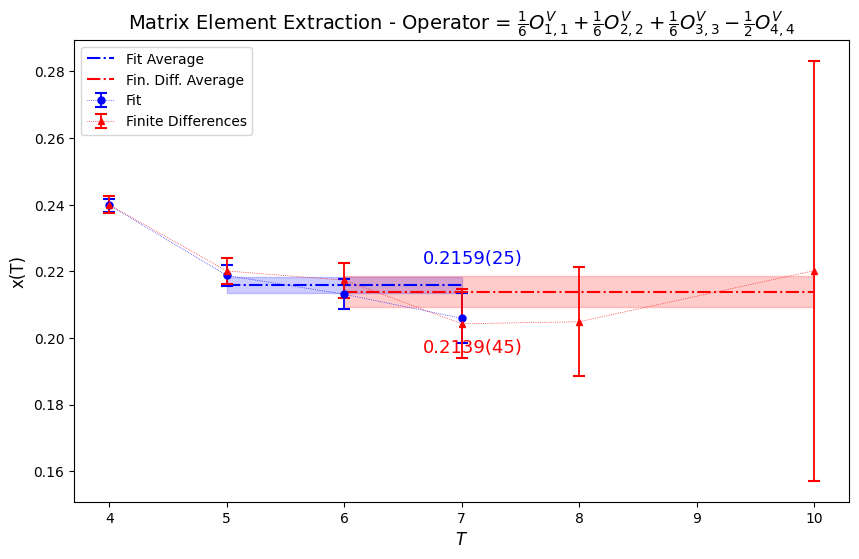

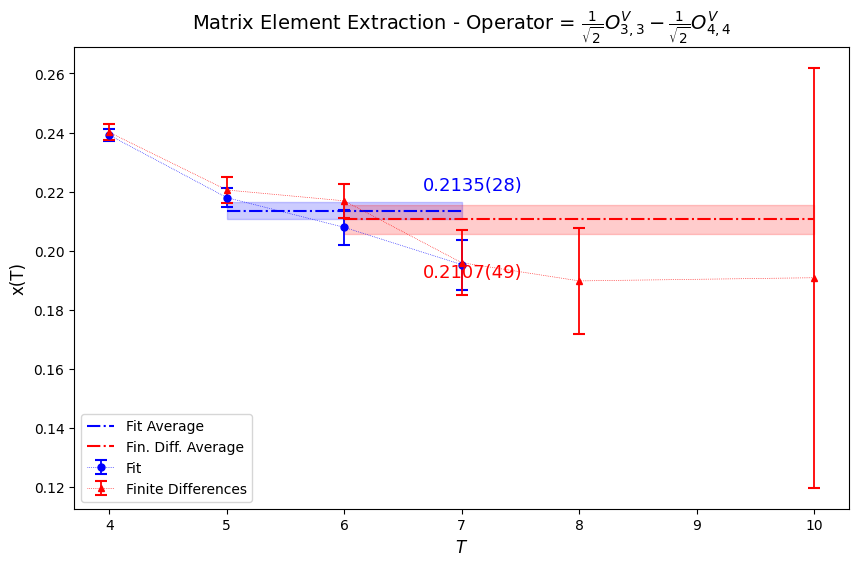

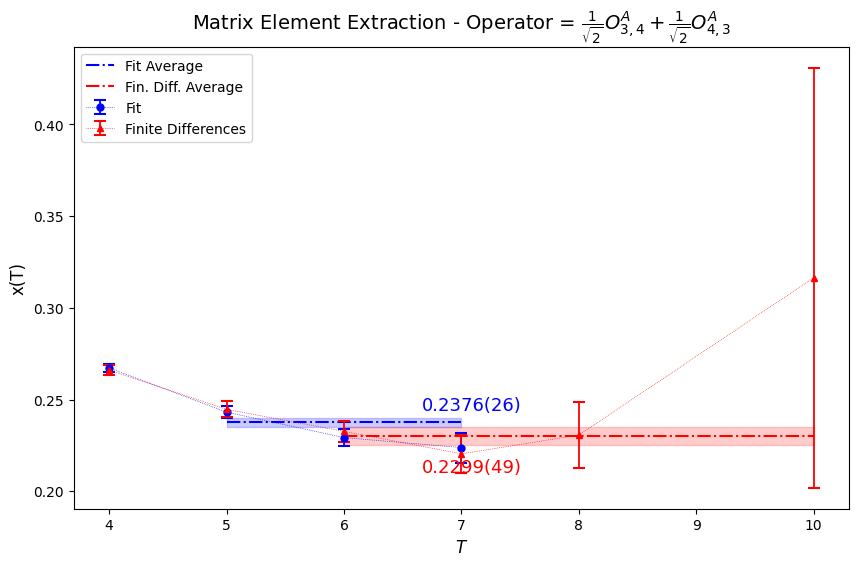

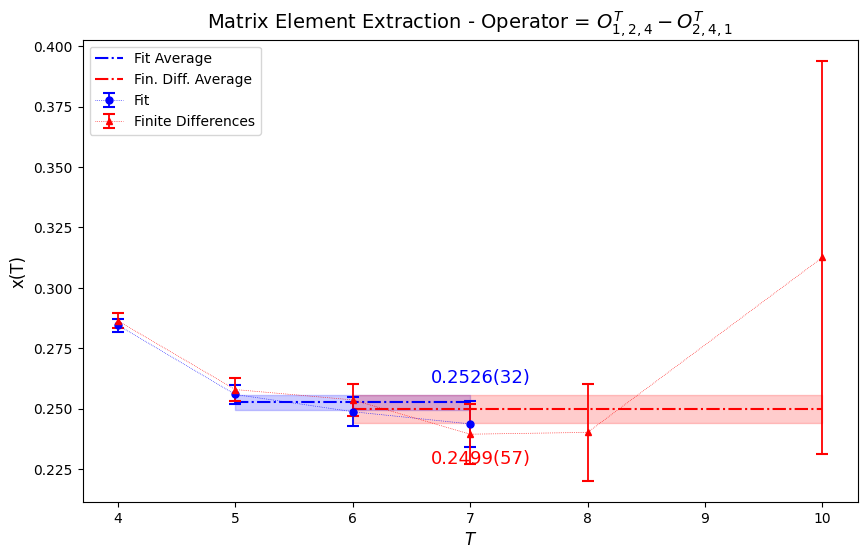

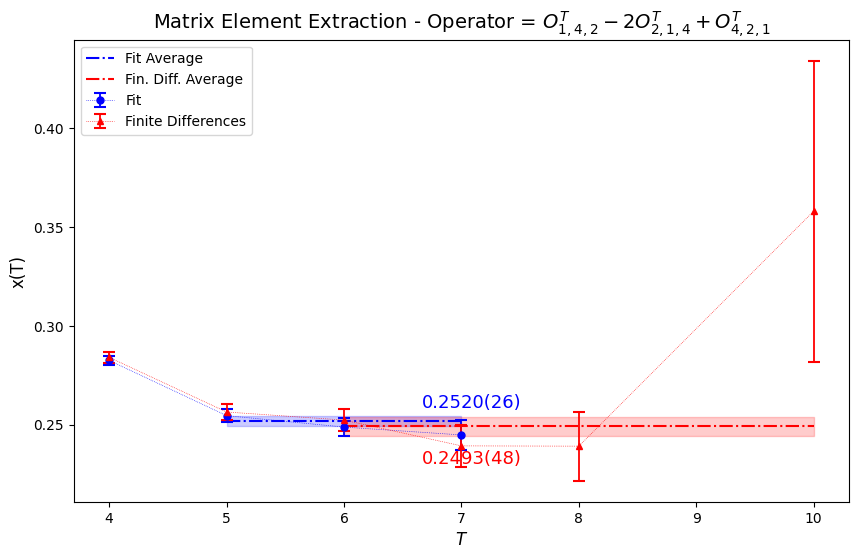

In [43]:
moments = True

#loop over selected operators (for each we make a plot)
for iop,op in enumerate(opAnalyzer.selected_op):

    #instantiate figure
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))

    ordinate_array_fit = moments_array_fit if moments else mat_ele_array_fit
    

    asc = np.array( [T for i,T in enumerate(opAnalyzer.chosen_T_list) if np.abs(ordinate_array_fit[iop][i].mean)>10**(-18)] )
    ord = np.array( [e.mean for e in ordinate_array_fit[iop] if np.abs(e.mean)>10**(-18)] )
    ord_sig = np.array( [e.sdev for e in ordinate_array_fit[iop] if np.abs(e.mean)>10**(-18)] )

    _=ax.errorbar(asc, ord,yerr=ord_sig, marker = 'o', markersize = 5, linewidth = 0.5,elinewidth=1.3, linestyle='dotted',label=f"Fit",color="blue",  capsize=4.0, capthick=1.5)

    #fit_avg = np.average([ e for e in ordinate_array_fit[iop] if np.abs(e.mean)>10**(-18) ] , weights=[ e.sdev**(-2) for e in ordinate_array_fit[iop] if np.abs(e.mean)>10**(-18) ] )
    fit_avg, iTmin = average_moments_over_T(ordinate_array_fit[iop], chi2=10.0)
    _=ax.hlines(fit_avg.mean,min(asc[iTmin:]),max(asc[iTmin:]),color="blue",linestyles="-.", label="Fit Average")
    _=ax.fill_between(asc[iTmin:],fit_avg.mean+fit_avg.sdev,fit_avg.mean-fit_avg.sdev,color="blue",alpha=0.2)


    ordinate_array_diff = moments_array if moments else mat_ele_array
    

    asc = np.array( [T for i,T in enumerate(opAnalyzer.chosen_T_list) if np.abs(ordinate_array_diff[iop][i].mean)>10**(-18)] )
    ord = np.array( [e.mean for e in ordinate_array_diff[iop] if np.abs(e.mean)>10**(-18)] )
    ord_sig = np.array( [e.sdev for e in ordinate_array_diff[iop] if np.abs(e.mean)>10**(-18)] )

    _=ax.errorbar(asc, ord,yerr=ord_sig, marker = '^', markersize = 5, linewidth = 0.5, elinewidth=1.3, linestyle='dotted',label=f"Finite Differences",color="red",   capsize=4.0, capthick=1.5)

    #diff_avg = np.average([ e for e in ordinate_array_diff[iop] if np.abs(e.mean)>10**(-18) ] , weights=[ e.sdev**(-2) for e in ordinate_array_diff[iop] if np.abs(e.mean)>10**(-18) ] )
    diff_avg, iTmin = average_moments_over_T(ordinate_array_diff[iop], chi2=1.0)
    _=ax.hlines(diff_avg.mean,min(asc[iTmin:]),max(asc[iTmin:]),color="red",linestyles="-.", label="Fin. Diff. Average")
    _=ax.fill_between(asc[iTmin:],diff_avg.mean+diff_avg.sdev,diff_avg.mean-diff_avg.sdev,color="red",alpha=0.2)


    if fit_avg >= diff_avg:
        _=ax.text(np.mean(asc),fit_avg.mean + 2.5*fit_avg.sdev,str(fit_avg),color="blue", fontsize=13)
        _=ax.text(np.mean(asc),diff_avg.mean - 4.0*diff_avg.sdev,str(diff_avg),color="red", fontsize=13)
    else:
        _=ax.text(np.mean(asc),fit_avg.mean - 4.0*fit_avg.sdev,str(fit_avg),color="blue", fontsize=13)
        _=ax.text(np.mean(asc),diff_avg.mean + 2.5*diff_avg.sdev,str(diff_avg),color="red", fontsize=13)



    

    _=ax.legend()
    _=ax.set_title(r"Matrix Element Extraction - Operator = ${}$".format(op),fontsize=14)
    _=ax.set_xlabel(r"$T$", fontsize=12)
    _=ax.set_ylabel(r"x(T)" if moments else r"\mathcal{M}(T)", fontsize=12)

    plt.savefig(f"plots/S_extraction_comparison_iop{iop}.png")